In [1]:
import pandas as pd
import numpy as np
import alphalens # 因子分析

import pickle

import scipy.stats as st
import statsmodels.api as sm

from tqdm import *
from jqdata import *

# 多进程
from CalFunc import *  # <===自定义的需要多进程计算的函数
from multiprocessing import Pool 

pd.set_option('display.max_r',10)

m_cpu= 2 # cpu几核就设置几

# 日期
import calendar # 日历
from dateutil.parser import parse

# 画图
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import matplotlib.ticker as ticker 
import matplotlib.gridspec as mg # 不规则子图
pd.plotting.register_matplotlib_converters()

# 设置字体 用来正常显示中文标签
mpl.rcParams['font.sans-serif'] = ['SimHei']
#plt.rcParams['font.family']='serif' # pd.plot中文
# 用来正常显示负号
mpl.rcParams['axes.unicode_minus'] = False
# 图表主题
plt.style.use('seaborn')

# 买卖压力度量因子的逻辑

## 市场微观分析

从微观上看，股票的任何一笔成交价格都是买卖双方撮合的结果，在某一特定价格区域，如果买盘量大于卖盘量，低价位卖盘撮合完成后会撮合高价位的卖盘，最终成交价格上涨，相反卖盘量大于买盘，最终成交价格下跌。 

我们假设市场上分成两类投资者A和B，在某一时间区间内对某只股票，A类投资者已经根据事先的研究判断决定了买卖方向，等待交易时机，该类投资者一般着眼于中长期，B类交易者对股票没有方向判别，相机而动，属于噪音交易者或者专注于短期投机、短期套利的投资者。从以上的分析我们可以看出，来自B类投资者关注的视野较短，买盘或者卖盘不稳定，买卖的连续性不高，因此本期的买盘卖盘对未来影响不大。我们重点关注 A类投资者，假设投资者已经确定在某时间区间内买入某只股票，那么一个理性的投资者应该在区间内逢低买入，这样就会造成在区间内价格相对较低的位置成交量大，价格相对较高时成交量小， 相反A类投资者卖出时，成交量在价格较高时较大，价格较低时成交量小。通过对A类投资者交易行为分析，**我们发现当A类投资者买入时，股票在价格低位的成交量相对于价格高位的成交量大，当A类投资者卖出时，股票在价格低位的成交量相对价格高位的低。**

最后，我们要说明的是A类投资者如何识别当前价格是区间内低位还是区间内高位，从技术上讲，投资者只能从左侧看是不是高位或者低位，如果 A类投资者在左侧高位卖出时， 股票价格会向下承压，这样从右侧看处于高位的可能性也较大，相反，如果 A 类投资者在左侧低位买入，股票大概率会上涨，这样从右侧看处于低位的可能性也较大。因此，**A 类投资者逢低买入或者逢高卖出是个自适应的过程，即使投资者不能够事先判断局部高位、或者局部低位，也能通过自己的交易行为实现。**

**两类投资者特点**

```
A类投资者

- 事先既定交易方向
- 等待交易时机
- 着眼于中长期
- 买卖盘稳定性高
- 对后期股票价格影响大


B类投资者

- 事先没有交易方向
- 即时完成交易
- 着眼于短期
- 买卖盘不稳定
- 对后期影响小
```

综上，如果在在某一区间内A类投资者持续买入，那么成交量在价格低位相对较大，如果持续卖出，那么成交量在价格高位相对较大。因此，我们就可以根据股票价格和成交量的 关系来度量 A 类投资者是买卖压力，考虑到 A 类投资者的投资尺度相对较长，买卖持续性较 强，买入压力较大的股票后期相对收益可能更高，卖出压力较大的股票后期相对收益可能更低。

# 第一部分：基础数据、函数准备、因子生成


## 因子定义

可以通过股票价格和成交量的关系来度量A类投资者的买卖压力，成交量在价格高位相对更大时卖压较大，成交量在价格低位相对更大时买压更大。成交量和价格的关系会直接影响到区间内成交量加权价格 vwap 的大小，假设成交量和价格没有关系，每个交易日成交量一样，那么区间内价格均值就是每个交易日价格的简单平 均，如果价格高位的成交量大，那么区间内 vwap 较高，如果价格低位的成交量大，那么区间 内 vwap 较低。基于这个思路我们提出了一种度量股票买卖压力的方法，股票 i 在第 m 个月
的均价偏差（average price bias, APB）定义如下：

<font size=4.5>$$APB_{i,m}=ln(\frac{\frac{1}{T}\sum^T_{i=1}vwap^{t}_{i,m}}{\frac{1}{\sum^T_{t=1}volu^{t}_{i,m}}\sum^T_{t=1}volu^t_{i,m}·vwap^t_{i,m}})$$</font>

其中，$vwap^{t}_{i,m}$ 𝑡 表示股票 i 在第m个月份第 t 个交易日的 vwap 均价，$volu^t_{i,m}$ 𝑡 表示股票 i在第m个月份第 t 个交易日的成交量，这里均价和成交量都经过复权调整，股票 i 在第m个 月有 T 个交易日，考虑到数据分布，指标取对数化处理。 

APB 定义中的分子是各个交易日 vwap 的算术平均值，分母是各个交易日成交量加权的均值，也就是这个月度区间内的 vwap。**如果股票在价格高位成交量大，那么成交量加权的均值大于算术平均，APB 取值小于零，相反，如果股票在价格低位成交量大，那么成交量加权的均值小于算术平均，APB 取值大于零，APB 取值越大，股票面临的买压越大，卖压越小。**


## 数据准备

- 获取原始行情数据，以及基础函数准备。起始时间为2014-01-01, 结束时间为2020-04-01

## 生成日度买卖压因子（apb_1d）

- 每日基于日内30分钟K线度量APB（30分钟等权加权均价和成交量加权均价之比的对数），过去30个交易日求均值。
- 每天一共9个三十分钟时间段，少于5个时间段有数据的股票不计算日度因子；在过去30个交易日中，少于15个交易日有因子数据的股票不计算apb_1d因子。

In [2]:
# 设置时间范围
start_date, end_date = '2014-01-01', '2020-04-01'
begin_date = get_trade_days(end_date=start_date,count=30)[0]
# 获取截面成分股
security_list = get_index_stocks('000002.XSHG') + get_index_stocks(
    '399107.XSHE')

In [2]:
# 获取日内数据 计算用于apb_1d
def GetData(security_list: list, start_date: str, end_date: str):

    days = get_trade_days(start_date, end_date)
    temp = []

    for trade in tqdm(days, desc='下载中'):

        price_df = get_price(
            security_list,
            start_date=str(trade) + ' 9:30:00',
            end_date=str(trade) + ' 15:00:00',
            frequency='30m',
            fields=['money', 'volume'],
            panel=False)

        temp.append(get_dailyapb(price_df))

    df = pd.concat(temp)

    return df


# 计算apb
def get_dailyapb(df: pd.DataFrame,) -> pd.Series:

    def cal_apb(df):

        if not df.empty and len(df) >= 5:
            # 未取对数 对数计算较为简单可以后续计算
            return np.mean(df['vwap']) / np.average(
                df['vwap'], weights=df['volume'])
        else:
            return np.nan

    df = df.query('volume!=0') # 过滤成交量为0的
    df['vwap'] = df['money'] / df['volume']
    df = df.dropna() # 过滤na
    apb = df.groupby(['code', pd.Grouper(key='time', freq='D')]).apply(cal_apb)
    apb.name = 'APB'
    return apb


# 计算apb_1d
def Cal_APBN(ser: pd.Series):
    if len(ser) >= 15:
        return np.mean(ser)
    else:
        return np.nan

In [4]:
# 11h24m24s
# 获取分钟数据
daily_df = GetData(security_list,begin_date,end_date)
daily_df = daily_df.to_frame()
daily_df.columns = ['apb'] 

# 数据储存
daily_df.to_csv('../../Data/apb_1d.csv')

下载中:   0%|          | 0/1553 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
下载中: 100%|██████████| 1553/1553 [10:43:29<00:00, 23.79s/it] 


## 生成五日买卖压因子(apb_5d)

- 基于过去5个交易日滚动计算APB，过去30个交易日求均值。
- 在过去5个交易日中，少于3个交易日有数据的股票不计算日度因子；在过去30个交易日中，少于15个交易日有因子数据的股票不计算apb_5d因子。

In [3]:
def OffsetDate(end_date: str, count: int) -> datetime.date:
    '''
    end_date:为基准日期
    count:为正则后推，负为前推
    -----------
    return datetime.date
    '''

    trade_date = get_trade_days(end_date=end_date, count=1)[0]
    if count > 0:
        # 将end_date转为交易日

        trade_cal = get_all_trade_days().tolist()

        trade_idx = trade_cal.index(trade_date)

        return trade_cal[trade_idx + count]

    elif count < 0:

        return get_trade_days(end_date=trade_date, count=abs(count))[0]

    else:

        raise ValueError('别闹！')


# 多进程
def apply_parl(groupeds, func):

    with Pool(m_cpu) as p:

        res_list = p.map(func, [g for _, g in groupeds])

    return pd.concat(res_list)


def get_group_ids(df, key):

    codes = df.index.get_level_values(key).drop_duplicates()

    mapping = pd.Series(np.arange(0, len(codes)), index=codes)

    res = df.index.get_level_values(key).map(mapping) % (m_cpu * 10)
    
    return res.values

In [4]:
# 滞后一期方便计算next_ret
offset_date = OffsetDate(end_date,1)

# 数据获取
data = get_price(
    security_list,
    begin_date,
    offset_date,
    fields=['close', 'volume','paused'],
    panel=False)
    
data.set_index(['code', 'time'], inplace=True)
data = data[data['volume']!=0]

In [1]:
# 多进程计算

start = time.time()
print('vwap开始计算...')
ids = get_group_ids(data, key='code')
vwap = apply_parl(data.groupby(ids), rolling_5vwap)

end = time.time()
print("多进程(多个code处理)计算vwap :" + str(end - start))

data = data.reindex(vwap.index)
data['vwap'] = vwap

print('开始计算apb...')

start = time.time()

ids = get_group_ids(data, key='code')
apb = apply_parl(data.groupby(ids), rolling_5apb)

end = time.time()

print("多进程(多个code处理)计算apb :" + str(end - start))

data = data.reindex(apb.index)
data['apb'] = apb

print('计算完毕...')

vwap开始计算
多进程(多code处理)计算vwap:2312.0994269275665
开始计算apb
多进程(多code处理)计算apb:3339.2367733412925
计算完毕


In [4]:
# 存储
data.to_csv('../../Data/apb_5d.csv')

## 生成30日买卖压因子（apb_30d）
- 基于过去30个交易日滚动计算APB，再过去30个交易日求均值。
- 在过去30个交易日中，少于15个交易日有数据的股票不计算日度因子；在过去30个交易日中，少于15个交易日有因子数据的股票不计算apb_30d因子。

In [2]:
start = time.time()
print('vwap开始计算...')
ids = get_group_ids(data, key='code')
vwap = apply_parl(data.groupby(ids), rolling_30vwap)

end = time.time()
print("多进程(多个code处理)计算vwap :" + str(end - start))

data = data.reindex(vwap.index)
data['vwap'] = vwap

print('开始计算apb...')

start = time.time()

ids = get_group_ids(data, key='code')
apb = apply_parl(data.groupby(ids), rolling_30apb)

end = time.time()

print("多进程(多个code处理)计算apb :" + str(end - start))

data = data.reindex(apb.index)
data['apb'] = apb

print('计算完毕...')

vwap开始计算
多进程(多code处理)计算vwap:1721.9094269275665
开始计算apb
多进程(多code处理)计算apb:2038.2357723712921
计算完毕


In [3]:
# 存储
data.to_csv('../../Data/apb_30d.csv')

# 第二部分：因子分析分析

In [5]:
def load_factor(path):

    df = pd.read_csv(path, index_col=[0, 1], parse_dates=True)
    log_apb = np.log(df['apb'])
    apb_30d = log_apb.groupby(level='code').transform(
        lambda x: x.rolling(30).mean())

    factor_ser = apb_30d.swaplevel().sort_index()
    factor_ser.index.names = ['date', 'assent']

    return factor_ser


def GetFactorRet(xdf: pd.DataFrame):
    
    factor_returns = pd.pivot_table(
        xdf.reset_index(), index='date', columns='factor_quantile', values=1)
    
    factor_returns['long/short'] = factor_returns[5] - factor_returns[1]
    
    return factor_returns

def factor_summary(factor_list: list) -> pd.DataFrame:
    
    t_list = []
    f_list = []
    for f_df in factor_list:
        
        t_list.append(pd.Series(GetTReport(f_df)))
        f_list.append(pd.Series(GetICReport(f_df)))
        
    return pd.concat(t_list,axis=1),pd.concat(f_list,axis=1)
        
def GetTReport(factor_df: pd.DataFrame):

    rept = {}
    tvalue_ser = factor_df.groupby(level='date').apply(
        lambda x: Get_Tvalue(x['factor'], x[1]))
    abs_tvalue_ser = abs(tvalue_ser)

    rept['t均值'] = tvalue_ser.mean()
    rept['|t|均值'] = abs_tvalue_ser.mean()
    rept['|t|>2占比'] = np.sum(
        np.where(abs_tvalue_ser > 2, 1, 0)) / len(abs_tvalue_ser)
    rept['因子收益均值'] = np.mean(factor_df[1])

    return rept


def GetICReport(factor_df: pd.DataFrame):

    rept = {}
    rank_IC = factor_df.groupby(level='date').apply(
        lambda x: st.pearsonr(x[1].rank(), x['factor'].rank())[0])

    rept['ic均值'] = rank_IC.mean()
    rept['ic标准差'] = rank_IC.std()
    rept['IC_IR'] = rank_IC.mean()/rank_IC.std()
    rept['IC大于0的比率'] = len(rank_IC[rank_IC > 0])/len(rank_IC)
    
    return rept

# t_value


def Get_Tvalue(factor, returns):
    x = sm.add_constant(factor)
    mod = sm.OLS(returns, x)
    res = mod.fit()

    return res.tvalues[0]



def GetRisk(factor_df:pd.DataFrame):
    
    f_returns = GetFactorRet(factor_df)
    f_cum = (1+f_returns).cumprod()
    
    # 计算年化收益率
    annual_ret = (f_cum.iloc[-1] - 1)**(250. / float(len(f_cum))) - 1
    
    # 计算累计收益率
    cum_ret_rate = f_cum.iloc[-1] - 1
    
    mdd = GetMaxdrawdown(f_cum)
                                        
    # 
    volatility = np.std(f_returns)*np.sqrt(250)
    shape = (annual_ret-0.04) / volatility
    
    df = pd.concat([annual_ret,cum_ret_rate,mdd,shape,volatility],axis=1)
    df.columns = ['年化收益','累计收益','最大回撤','夏普','波动率']
    return df

def GetMaxdrawdown(df:pd.DataFrame):
    
    md = {}
    for label,col in df.items():
        
        # 最大回撤
        max_nv = np.maximum.accumulate(col)
        mdd = -np.min(col/max_nv-1)
        
        md[label] = mdd
        
    return pd.Series(md)

In [6]:
# 读取因子数据
factor_1d = load_factor('../../Data/apb_1d.csv')
factor_5d = load_factor('../../Data/apb_5d.csv')
factor_30d = load_factor('../../Data/apb_30d.csv')

# 因子回测期间
factor_1d = factor_1d.loc['2014-01-02':'2019-12-31']
factor_5d = factor_5d.loc['2014-01-02':'2019-12-31']
factor_30d = factor_30d.loc['2014-02-18':'2019-12-31']

print('apb_1d')
alphalens.utils.print_table(factor_1d.tail())

print('apb_5d')
alphalens.utils.print_table(factor_5d.tail())

print('apb_30d')
alphalens.utils.print_table(factor_30d.tail())

apb_1d


apb
date       assent               
2019-12-31 603995.XSHG       NaN
           603996.XSHG -0.001648
           603997.XSHG -0.000593
           603998.XSHG -0.001333
           603999.XSHG -0.000998

apb_5d


apb
date       assent               
2019-12-31 603949.XSHG       NaN
           603958.XSHG -0.003343
           603963.XSHG -0.000483
           603968.XSHG  0.000332
           603976.XSHG -0.002123

apb_30d


apb
date       assent               
2019-12-31 603995.XSHG       NaN
           603996.XSHG -0.002563
           603997.XSHG -0.000766
           603998.XSHG  0.000329
           603999.XSHG -0.004468

In [7]:
# 获取收盘数据
# 数据前推30日后推15日
pricing = get_price(security_list,begin_date,OffsetDate(end_date,15),fields='close',panel=False)
pricing = pd.pivot_table(pricing, index = 'time', columns = 'code', values = 'close').shift(-1)

# 查看数据结构
pricing.head()

code,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,000012.XSHE,000014.XSHE,000016.XSHE,000017.XSHE,000019.XSHE,000020.XSHE,000021.XSHE,000023.XSHE,000025.XSHE,000026.XSHE,000027.XSHE,000028.XSHE,000029.XSHE,000030.XSHE,000031.XSHE,000032.XSHE,000034.XSHE,000035.XSHE,000036.XSHE,000037.XSHE,000038.XSHE,000039.XSHE,000040.XSHE,000042.XSHE,000045.XSHE,000046.XSHE,000048.XSHE,000049.XSHE,000050.XSHE,000055.XSHE,...,603929.XSHG,603933.XSHG,603936.XSHG,603937.XSHG,603938.XSHG,603939.XSHG,603948.XSHG,603949.XSHG,603955.XSHG,603956.XSHG,603958.XSHG,603959.XSHG,603960.XSHG,603963.XSHG,603966.XSHG,603967.XSHG,603968.XSHG,603969.XSHG,603970.XSHG,603976.XSHG,603977.XSHG,603978.XSHG,603979.XSHG,603980.XSHG,603982.XSHG,603983.XSHG,603985.XSHG,603986.XSHG,603987.XSHG,603988.XSHG,603989.XSHG,603990.XSHG,603991.XSHG,603992.XSHG,603993.XSHG,603995.XSHG,603996.XSHG,603997.XSHG,603998.XSHG,603999.XSHG
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-20,7.47,6.94,12.19,2.75,4.92,9.34,2.23,4.66,7.77,6.84,5.39,11.21,1.72,4.19,3.82,6.65,5.13,7.88,5.13,6.93,3.28,37.21,3.92,3.93,3.76,7.64,4.17,5.89,2.01,3.96,7.40,10.51,4.12,12.28,7.44,4.31,9.31,38.89,11.30,3.36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.03,NaN,NaN,NaN,NaN,NaN
2013-11-21,7.32,6.84,12.16,2.73,5.02,9.43,2.26,4.86,7.78,6.78,5.39,11.45,1.71,4.19,3.80,6.52,5.08,7.80,5.07,7.01,3.24,36.91,3.86,3.87,3.70,7.56,4.16,5.84,1.98,3.93,7.43,10.46,4.12,12.45,7.42,4.29,9.31,37.80,11.22,3.36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.04,NaN,NaN,NaN,NaN,NaN
2013-11-22,7.23,6.77,12.08,2.72,5.21,9.43,2.27,4.86,7.88,6.84,5.45,11.47,1.70,4.19,3.84,6.55,5.09,7.80,5.00,6.94,3.23,37.02,3.87,3.89,3.70,7.50,4.16,5.82,1.96,4.02,7.38,10.42,4.11,12.29,7.42,4.21,9.31,39.19,11.18,3.37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.04,NaN,NaN,NaN,NaN,NaN
2013-11-25,7.22,6.71,12.17,2.65,5.03,9.42,2.26,4.85,7.73,6.70,5.39,11.02,1.72,4.19,3.84,6.72,5.16,7.88,5.08,6.91,3.26,36.61,3.78,3.88,3.66,7.54,4.19,5.69,1.93,4.18,7.39,10.23,4.09,12.19,7.41,4.24,9.31,39.20,11.21,3.37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.03,NaN,NaN,NaN,NaN,NaN
2013-11-26,7.27,6.73,12.47,2.65,4.99,9.55,2.23,4.89,7.73,6.70,5.41,11.13,1.72,4.19,3.85,6.71,5.22,7.92,5.20,7.03,3.27,36.31,3.84,3.92,3.69,7.63,4.26,5.73,1.93,4.10,7.50,10.34,4.10,12.19,7.47,4.23,9.31,42.28,11.30,3.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.02,NaN,NaN,NaN,NaN,NaN


In [9]:
# Ingest and format data
apb_30d = alphalens.utils.get_clean_factor_and_forward_returns(
    factor_30d, pricing, quantiles=5, periods=(1,))

apb_5d = alphalens.utils.get_clean_factor_and_forward_returns(
    factor_5d, pricing, quantiles=5, periods=(1,))

apb_1d = alphalens.utils.get_clean_factor_and_forward_returns(
    factor_1d, pricing, quantiles=5, periods=(1,))


Dropped 22.0% entries from factor data (22.0% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.
Dropped 20.2% entries from factor data (20.2% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.
Dropped 3.3% entries from factor data (3.3% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


回归法结果分析 


,t均值,|t|均值,|t|>2占比,因子收益均值
apb_1d,3.806882,24.359616,0.925496,0.000548
apb_5d,1.514841,11.240704,0.855182,0.000491
apb_30d,3.681558,28.073291,0.949538,0.000465


IC结果分析 


,ic均值,ic标准差,IC_IR,IC大于0的比率
apb_1d,0.026322,0.077095,0.341418,0.674641
apb_5d,0.026386,0.099890,0.264152,0.606726
apb_30d,0.004416,0.069918,0.063164,0.521677


因子收益分析
----------------------------------------
apb_1d


,1,2,3,4,5,long/short
年化收益,NaN,-0.124040,0.009198,0.121464,0.105732,0.252549
累计收益,-0.421553,0.460699,1.055045,1.955886,1.800686,3.735040
最大回撤,0.846773,0.737191,0.657118,0.554889,0.562464,0.188920
夏普,NaN,-0.502274,-0.095602,0.254429,0.195933,1.995010
波动率,0.329314,0.326595,0.322185,0.320184,0.335481,0.106540


apb_5d


,1,2,3,4,5,long/short
年化收益,NaN,-0.129266,0.072171,0.140424,0.125964,0.132001
累计收益,-0.111427,0.446326,1.500997,2.150711,1.996572,2.059772
最大回撤,0.794531,0.727575,0.611883,0.542913,0.554326,0.097685
夏普,NaN,-0.509520,0.100594,0.323372,0.270600,0.896508
波动率,0.351222,0.332207,0.319813,0.310552,0.317680,0.102622


apb_30d


,1,2,3,4,5,long/short
年化收益,-0.199663,-0.041225,0.009293,0.040381,-0.015921,-0.117371
累计收益,0.285509,0.789043,1.053439,1.249562,0.913634,0.495267
最大回撤,0.696124,0.651841,0.624466,0.594700,0.650571,0.154255
夏普,-0.714610,-0.257677,-0.097911,0.001180,-0.161167,-1.969240
波动率,0.335376,0.315221,0.313620,0.322433,0.346977,0.079915


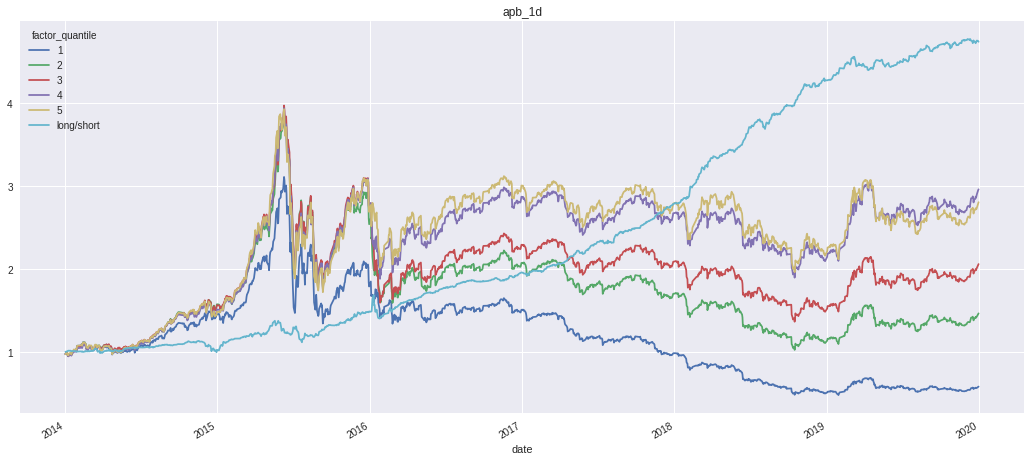

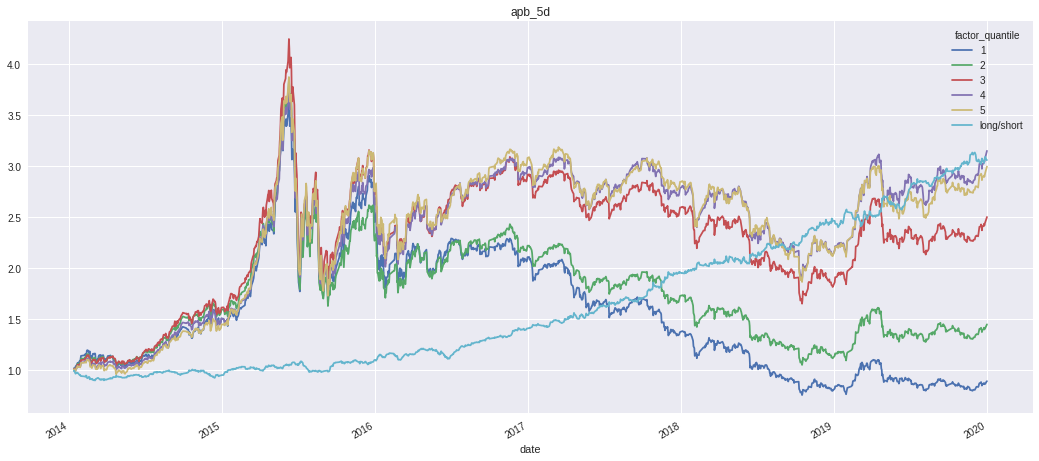

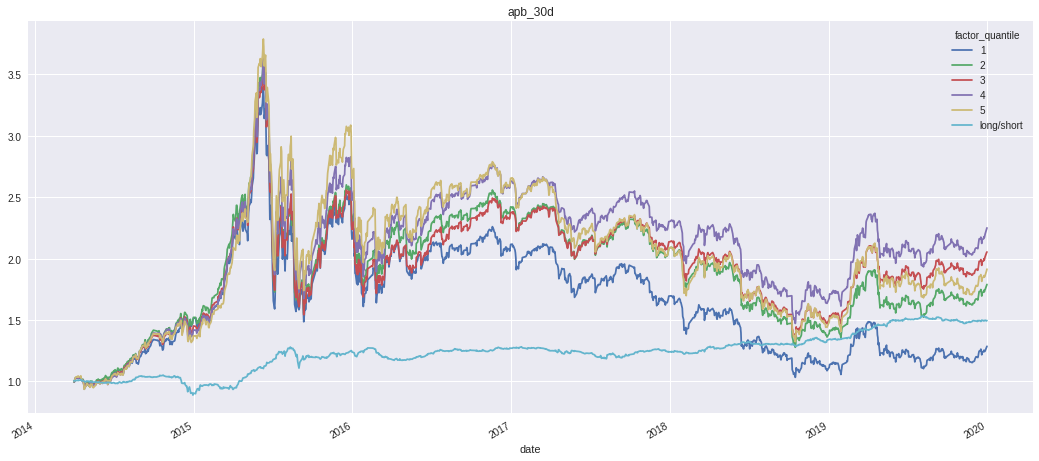

In [18]:
# 结果
t_rept, f_rept = factor_summary([apb_1d, apb_5d, apb_30d])
t_rept.columns = ['apb_1d', 'apb_5d', 'apb_30d']
f_rept.columns = ['apb_1d', 'apb_5d', 'apb_30d']

print('回归法结果分析 ')
alphalens.utils.print_table(t_rept.T)

print('IC结果分析 ')
alphalens.utils.print_table(f_rept.T)

print('因子收益分析')
print('-'*40)
print('apb_1d')
alphalens.utils.print_table(GetRisk(apb_1d).T)

print('apb_5d')
alphalens.utils.print_table(GetRisk(apb_5d).T)

print('apb_30d')
alphalens.utils.print_table(GetRisk(apb_30d).T)

# 图表
(1+apb_1d.pipe(GetFactorRet)).cumprod().plot(figsize=(18, 8), title='apb_1d')
(1+apb_5d.pipe(GetFactorRet)).cumprod().plot(figsize=(18, 8), title='apb_5d')
(1+apb_30d.pipe(GetFactorRet)).cumprod().plot(figsize=(18, 8), title='apb_30d')